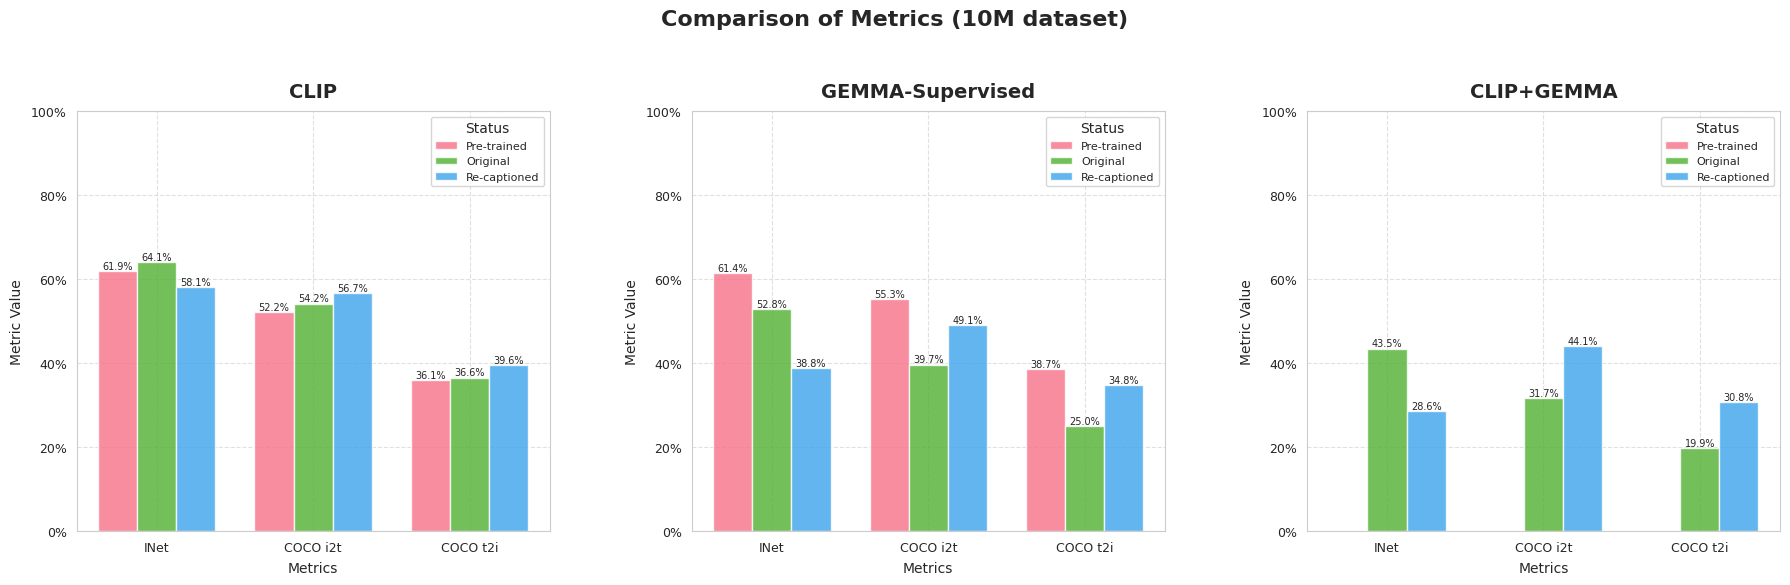

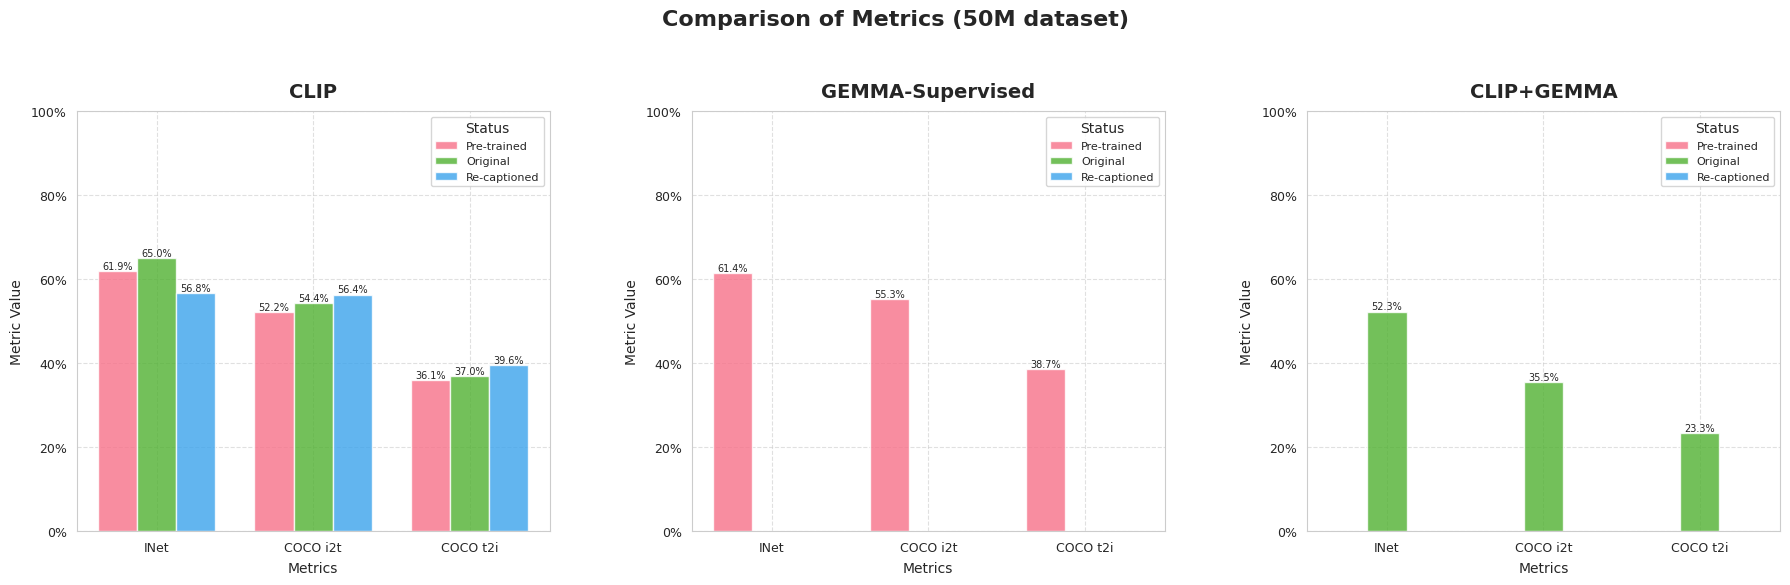


10M Dataset Results:

CLIP+GEMMA:
  z/0shot/imagenet2012_accuracy (Original): 0.4346
  z/0shot/imagenet2012_accuracy (Re-captioned): 0.2863
  z/0shot/imagenet2012_accuracy (Pre-trained): No data
  z/retr/coco_img2txt_recall@1 (Original): 0.3166
  z/retr/coco_img2txt_recall@1 (Re-captioned): 0.4406
  z/retr/coco_img2txt_recall@1 (Pre-trained): No data
  z/retr/coco_txt2img_recall@1 (Original): 0.1987
  z/retr/coco_txt2img_recall@1 (Re-captioned): 0.3077
  z/retr/coco_txt2img_recall@1 (Pre-trained): No data

CLIP:
  z/0shot/imagenet2012_accuracy (Original): 0.6413
  z/0shot/imagenet2012_accuracy (Re-captioned): 0.5806
  z/0shot/imagenet2012_accuracy (Pre-trained): 0.6187
  z/retr/coco_img2txt_recall@1 (Original): 0.5420
  z/retr/coco_img2txt_recall@1 (Re-captioned): 0.5668
  z/retr/coco_img2txt_recall@1 (Pre-trained): 0.5218
  z/retr/coco_txt2img_recall@1 (Original): 0.3657
  z/retr/coco_txt2img_recall@1 (Re-captioned): 0.3959
  z/retr/coco_txt2img_recall@1 (Pre-trained): 0.3606

GEMMA-

In [9]:
import json
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np

datacomp_recap_10M = {
    "FT_clip+gemma_recapF": "gs://us-central2-storage/tensorflow_datasets/post-training-datacomp-recap/clip_s3b_bs16k+gemma2b_lr1e-5_wd0.0_bs16k_epoch5_warm0.03_recapFalse_10-03_0440",
    "FT_clip+gemma_recapT": "gs://us-central2-storage/tensorflow_datasets/post-training-datacomp-recap/clip_s3b_bs16k+gemma2b_lr1e-5_wd0.0_bs16k_epoch5_warm0.03_recapTrue_10-03_0440",
    "FT_clip_recapF": "gs://us-central2-storage/tensorflow_datasets/post-training-datacomp-recap/clip_s3b_bs16k_lr1e-5_wd0.0_bs16k_epoch5_warm0.03_recapFalse_10-02_1912",
    "FT_clip_recapT": "gs://us-central2-storage/tensorflow_datasets/post-training-datacomp-recap/clip_s3b_bs16k_lr1e-5_wd0.0_bs16k_epoch5_warm0.03_recapT_10-01_1442",
    "FT_gemma-supervised_recapF": "gs://us-central2-storage/tensorflow_datasets/post-training-datacomp-recap/gemma-supervised_s3b_bs16k_lr1e-5_wd0.0_bs16k_epoch5_warm0.03_recapFalse_10-02_1727",
    "FT_gemma-supervised_recapT": "gs://us-central2-storage/tensorflow_datasets/post-training-datacomp-recap/gemma-supervised_s3b_bs16k_lr1e-5_wd0.0_bs16k_epoch5_warm0.03_recapTrue_10-02_1437",
}

datacomp_recap_50M = {
    "FT_clip+gemma_50M_recapF": "gs://us-central2-storage/tensorflow_datasets/post-training-datacomp-recap/clip_s3b_bs16k+gemma2b_lr1e-5_wd0.0_bs16k_epoch5_warm0.03_recapFalse_50M_10-03_0440",
    "FT_clip_50M_recapF": "gs://us-central2-storage/tensorflow_datasets/post-training-datacomp-recap/clip_s3b_bs16k_lr1e-5_wd0.0_bs16k_epoch5_warm0.03_recapFalse_50M_10-02_2028",
    "FT_clip_50M_recapT": "gs://us-central2-storage/tensorflow_datasets/post-training-datacomp-recap/clip_s3b_bs16k_lr1e-5_wd0.0_bs16k_epoch5_warm0.03_recapTrue_50M_10-02_2028",
}

pre_trained_models = {
    "Pre-FT_CLIP": "gs://us-central2-storage/tensorflow_datasets/vit-b-16_3b_pretraining/clip_bs16384_warm0.03_lr1e-3_wd1e-4_bf16_qknorm-F_b2-0.95_12lyr_07-25_1415",
    "Pre-FT_Gemma-supervised": "gs://us-central2-storage/tensorflow_datasets/mllm_ckpts/paligemma/gemma2b-partial_frozen99-0.01-gap_b16-F_contrastive_bs16k_s3b_lr1e-3_wd1e-4_bf16_09-01_0446",
}

def get_final_metrics(experiment_name, experiments):
    ckpt_path = experiments[experiment_name]
    metrics_path = f'{ckpt_path}/big_vision_metrics.txt'

    final_metrics = {}
    with tf.io.gfile.GFile(metrics_path, 'r') as f:
        lines = f.read().split('\n')
        last_line = json.loads(lines[-2])  # Use -2 to avoid empty last line
        metrics_of_interest = [
            "z/0shot/imagenet2012_accuracy",
            "z/retr/coco_img2txt_recall@1",
            "z/retr/coco_txt2img_recall@1",
        ]
        for key in metrics_of_interest:
            if key in last_line:
                final_metrics[key] = last_line[key]
    return final_metrics

def prepare_plot_data(all_metrics, dataset_size, pre_trained_metrics=None):
    plot_data = []
    for exp, metrics in all_metrics.items():
        model_type = 'CLIP' if 'clip_recap' in exp or 'clip_50M' in exp else ('CLIP+GEMMA' if 'clip+gemma' in exp else 'GEMMA-Supervised')
        recap = 'Re-captioned' if 'recapT' in exp else 'Original'
        
        for metric, value in metrics.items():
            plot_data.append({
                'Model': model_type,
                'Recap': recap,
                'Metric': metric,
                'Value': value,
                'Dataset': f'{dataset_size}M'
            })
    
    if pre_trained_metrics:
        for exp, metrics in pre_trained_metrics.items():
            model_type = 'CLIP' if 'CLIP' in exp else 'GEMMA-Supervised'
            for metric, value in metrics.items():
                plot_data.append({
                    'Model': model_type,
                    'Recap': 'Pre-trained',
                    'Metric': metric,
                    'Value': value,
                    'Dataset': f'{dataset_size}M'
                })
    
    return pd.DataFrame(plot_data)
def create_beautiful_plots(df, dataset_size):
    # Set the style and color palette
    sns.set_style("whitegrid")
    colors = sns.color_palette("husl", 3)
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    fig.suptitle(f'Comparison of Metrics ({dataset_size}M dataset)', fontsize=16, fontweight='bold', y=1.02)

    models = ['CLIP', 'GEMMA-Supervised', 'CLIP+GEMMA']
    metrics = df['Metric'].unique()
    
    for i, model in enumerate(models):
        model_data = df[df['Model'] == model]
        
        if not model_data.empty:
            ax = axes[i]
            x = np.arange(len(metrics))
            width = 0.25
            
            for j, status in enumerate(['Pre-trained', 'Original', 'Re-captioned']):
                values = [model_data[(model_data['Metric'] == metric) & (model_data['Recap'] == status)]['Value'].values[0] 
                          if not model_data[(model_data['Metric'] == metric) & (model_data['Recap'] == status)].empty 
                          else 0 for metric in metrics]
                rects = ax.bar(x + j*width, values, width, label=status, color=colors[j], alpha=0.8)
                
                # Add value labels on top of each bar
                for rect in rects:
                    height = rect.get_height()
                    if height > 0:
                        ax.text(rect.get_x() + rect.get_width()/2., height,
                                f'{height*100:.1f}%',
                                ha='center', va='bottom', fontsize=7)
            
            ax.set_title(model, fontsize=14, fontweight='bold', pad=10)
            ax.set_xticks(x + width)
            ax.set_xticklabels(['INet', 'COCO i2t', 'COCO t2i'], rotation=0)
            ax.set_xlabel('Metrics', fontsize=10, labelpad=5)
            ax.set_ylabel('Metric Value', fontsize=10, labelpad=5)
            ax.legend(title='Status', title_fontsize='10', fontsize='8', loc='upper right')
            ax.set_ylim(0, 1)
            
            # Improve tick label visibility
            ax.tick_params(axis='both', which='major', labelsize=9)
            
            # Add a subtle grid
            ax.grid(True, linestyle='--', alpha=0.6)
            
            # Set y-axis to percentage
            ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0%}'))
        else:
            axes[i].set_title(f"{model} (No data)", fontsize=14, fontweight='bold', pad=10)

    plt.tight_layout()
    plt.subplots_adjust(top=0.85, bottom=0.15, wspace=0.3)  # Adjust the top and bottom margins
    plt.show()

# Collect and process data for both 10M and 50M experiments
all_metrics_10M = {exp: get_final_metrics(exp, datacomp_recap_10M) for exp in datacomp_recap_10M.keys()}
all_metrics_50M = {exp: get_final_metrics(exp, datacomp_recap_50M) for exp in datacomp_recap_50M.keys()}
pre_trained_metrics = {exp: get_final_metrics(exp, pre_trained_models) for exp in pre_trained_models.keys()}

df_10M = prepare_plot_data(all_metrics_10M, 10, pre_trained_metrics)
df_50M = prepare_plot_data(all_metrics_50M, 50, pre_trained_metrics)

# Create beautiful plots for 10M and 50M experiments
create_beautiful_plots(df_10M, 10)
create_beautiful_plots(df_50M, 50)

# Print the results
for dataset, df in [("10M", df_10M), ("50M", df_50M)]:
    print(f"\n{dataset} Dataset Results:")
    for model in df['Model'].unique():
        print(f"\n{model}:")
        for metric in df['Metric'].unique():
            for recap in df['Recap'].unique():
                values = df[(df['Model'] == model) & (df['Metric'] == metric) & (df['Recap'] == recap)]['Value']
                if not values.empty:
                    value = values.values[0]
                    print(f"  {metric} ({recap}): {value:.4f}")
                else:
                    print(f"  {metric} ({recap}): No data")

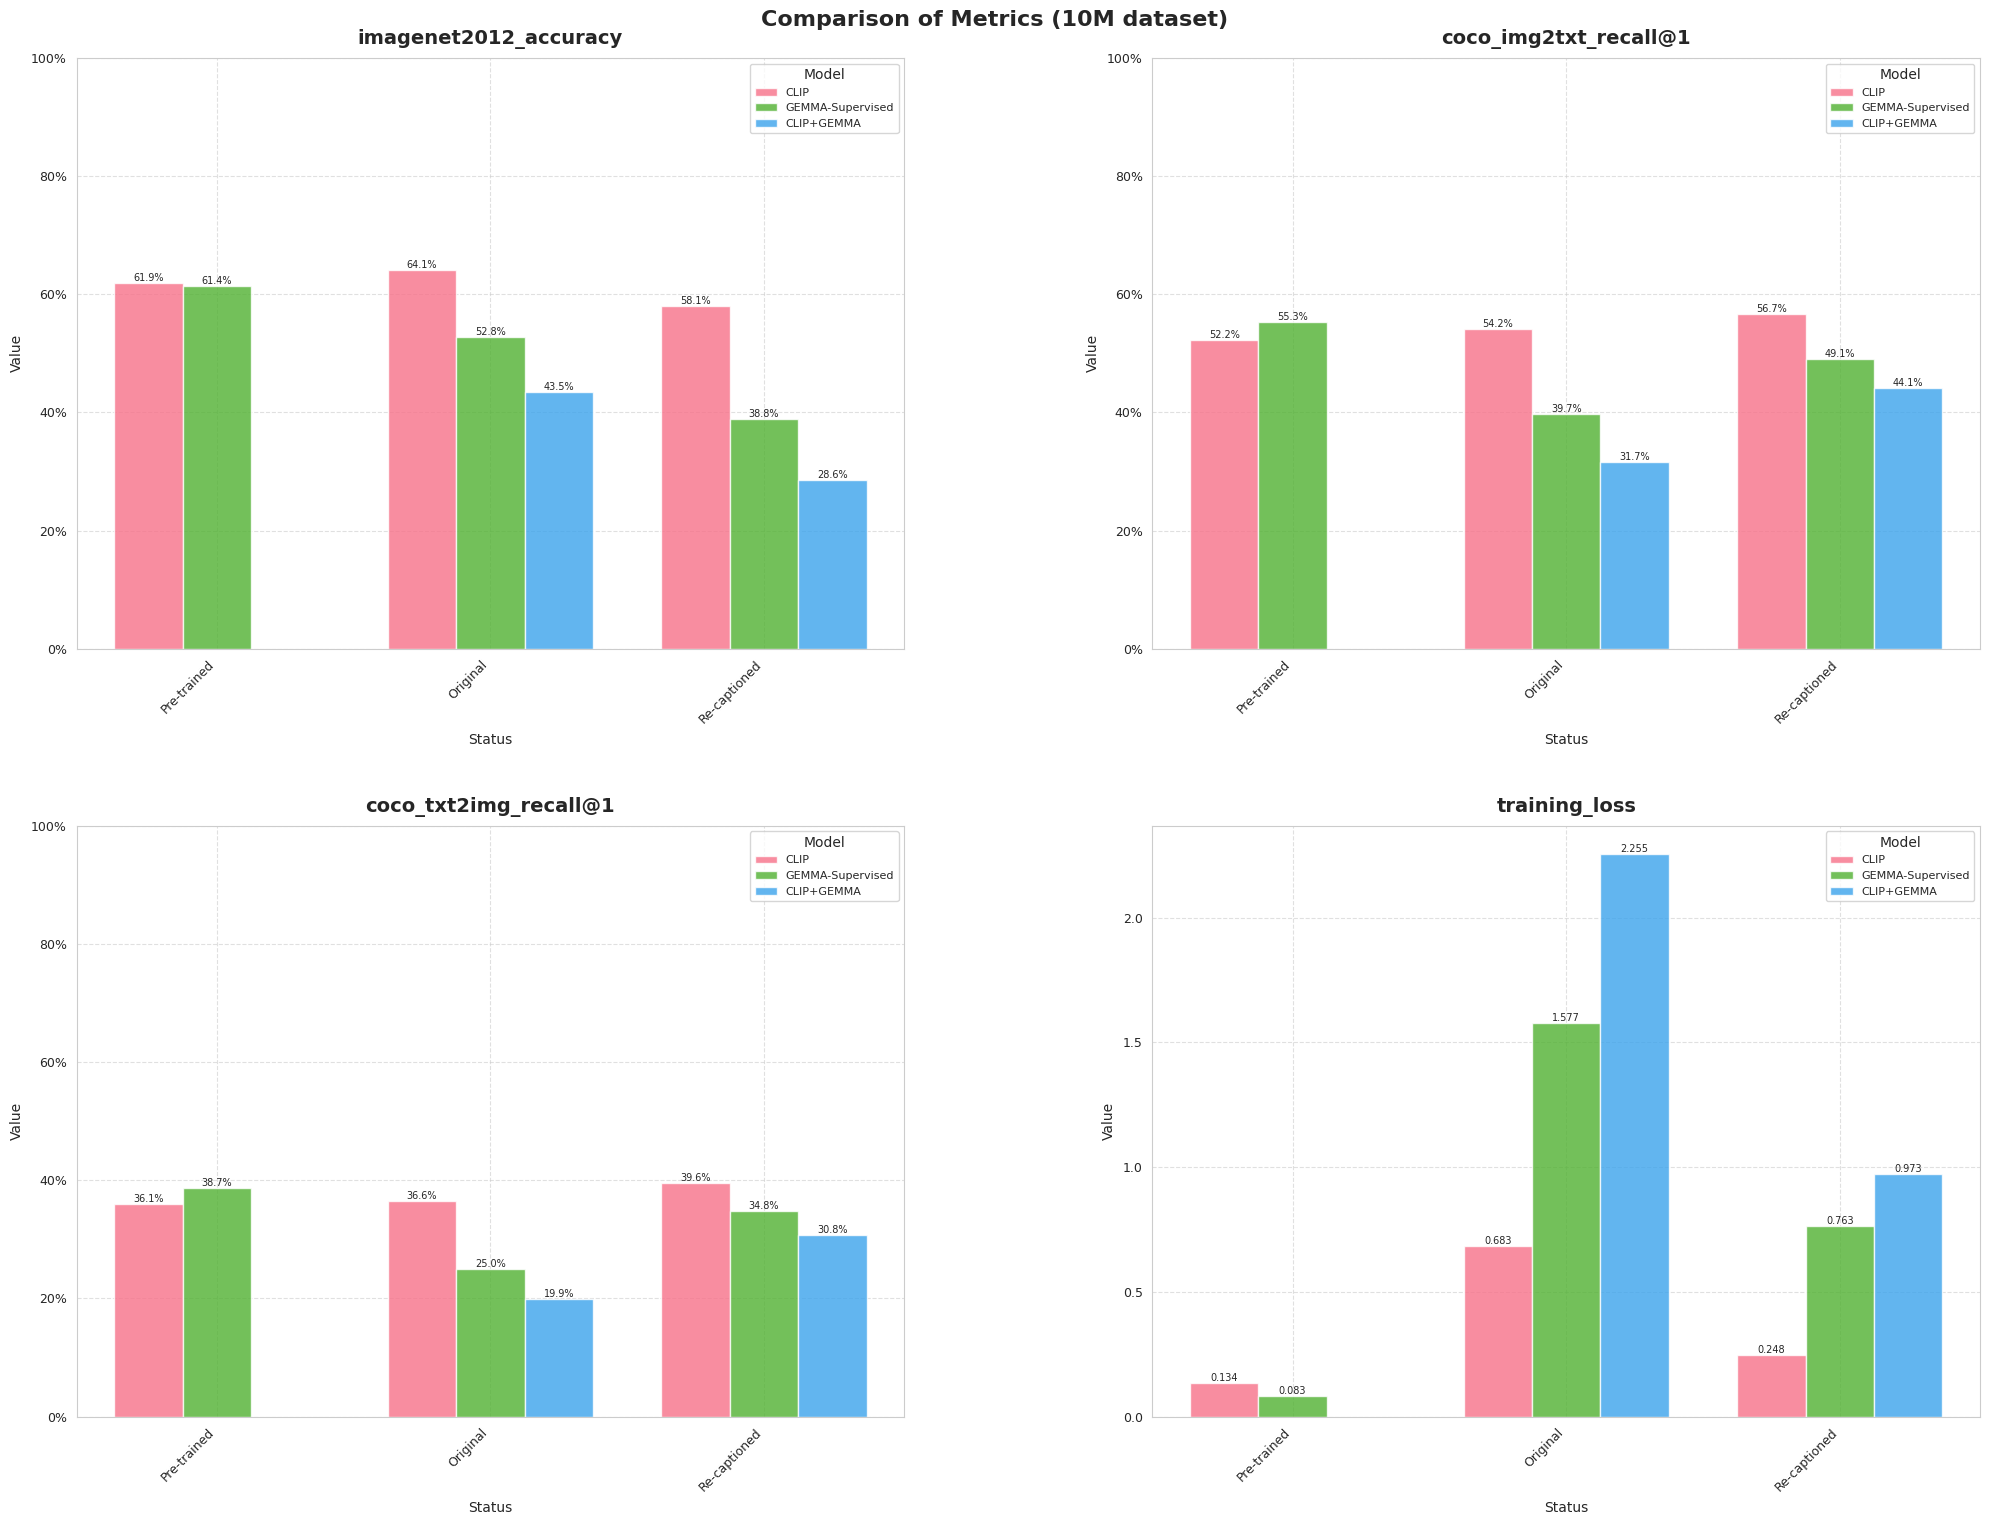

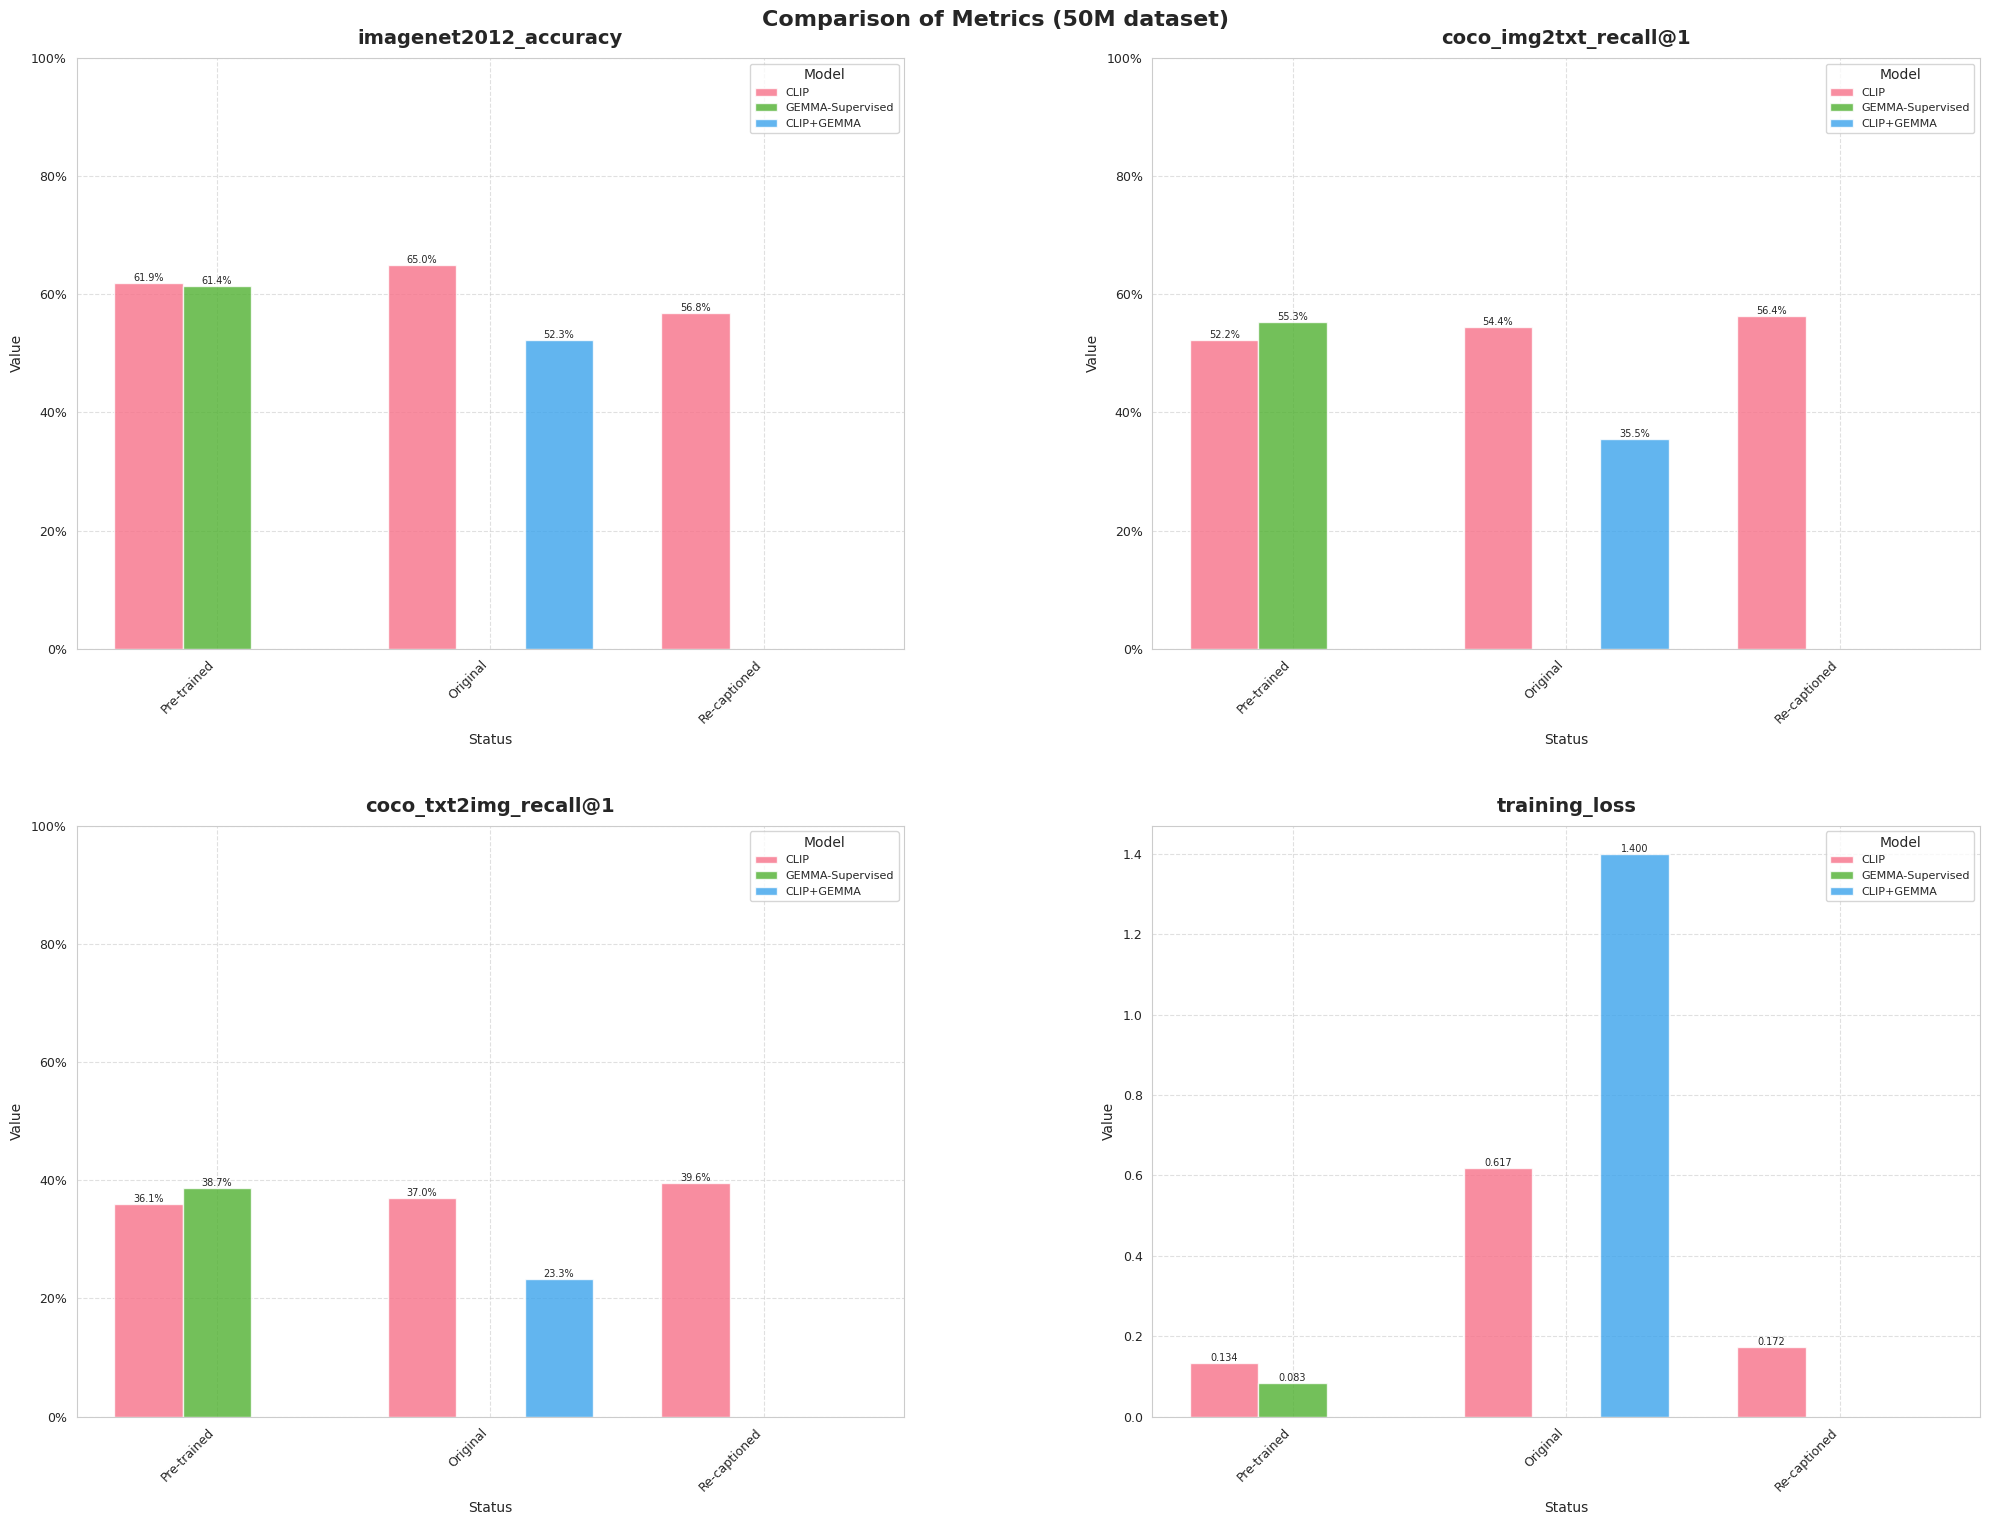


10M Dataset Results:

CLIP+GEMMA:
  z/0shot/imagenet2012_accuracy (Original): 0.4346
  z/0shot/imagenet2012_accuracy (Re-captioned): 0.2863
  z/0shot/imagenet2012_accuracy (Pre-trained): No data
  z/retr/coco_img2txt_recall@1 (Original): 0.3166
  z/retr/coco_img2txt_recall@1 (Re-captioned): 0.4406
  z/retr/coco_img2txt_recall@1 (Pre-trained): No data
  z/retr/coco_txt2img_recall@1 (Original): 0.1987
  z/retr/coco_txt2img_recall@1 (Re-captioned): 0.3077
  z/retr/coco_txt2img_recall@1 (Pre-trained): No data
  training_loss (Original): 2.2551
  training_loss (Re-captioned): 0.9725
  training_loss (Pre-trained): No data

CLIP:
  z/0shot/imagenet2012_accuracy (Original): 0.6413
  z/0shot/imagenet2012_accuracy (Re-captioned): 0.5806
  z/0shot/imagenet2012_accuracy (Pre-trained): 0.6187
  z/retr/coco_img2txt_recall@1 (Original): 0.5420
  z/retr/coco_img2txt_recall@1 (Re-captioned): 0.5668
  z/retr/coco_img2txt_recall@1 (Pre-trained): 0.5218
  z/retr/coco_txt2img_recall@1 (Original): 0.3657
 

In [10]:
import json
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np

datacomp_recap_10M = {
    "FT_clip+gemma_recapF": "gs://us-central2-storage/tensorflow_datasets/post-training-datacomp-recap/clip_s3b_bs16k+gemma2b_lr1e-5_wd0.0_bs16k_epoch5_warm0.03_recapFalse_10-03_0440",
    "FT_clip+gemma_recapT": "gs://us-central2-storage/tensorflow_datasets/post-training-datacomp-recap/clip_s3b_bs16k+gemma2b_lr1e-5_wd0.0_bs16k_epoch5_warm0.03_recapTrue_10-03_0440",
    "FT_clip_recapF": "gs://us-central2-storage/tensorflow_datasets/post-training-datacomp-recap/clip_s3b_bs16k_lr1e-5_wd0.0_bs16k_epoch5_warm0.03_recapFalse_10-02_1912",
    "FT_clip_recapT": "gs://us-central2-storage/tensorflow_datasets/post-training-datacomp-recap/clip_s3b_bs16k_lr1e-5_wd0.0_bs16k_epoch5_warm0.03_recapT_10-01_1442",
    "FT_gemma-supervised_recapF": "gs://us-central2-storage/tensorflow_datasets/post-training-datacomp-recap/gemma-supervised_s3b_bs16k_lr1e-5_wd0.0_bs16k_epoch5_warm0.03_recapFalse_10-02_1727",
    "FT_gemma-supervised_recapT": "gs://us-central2-storage/tensorflow_datasets/post-training-datacomp-recap/gemma-supervised_s3b_bs16k_lr1e-5_wd0.0_bs16k_epoch5_warm0.03_recapTrue_10-02_1437",
}

datacomp_recap_50M = {
    "FT_clip+gemma_50M_recapF": "gs://us-central2-storage/tensorflow_datasets/post-training-datacomp-recap/clip_s3b_bs16k+gemma2b_lr1e-5_wd0.0_bs16k_epoch5_warm0.03_recapFalse_50M_10-03_0440",
    "FT_clip_50M_recapF": "gs://us-central2-storage/tensorflow_datasets/post-training-datacomp-recap/clip_s3b_bs16k_lr1e-5_wd0.0_bs16k_epoch5_warm0.03_recapFalse_50M_10-02_2028",
    "FT_clip_50M_recapT": "gs://us-central2-storage/tensorflow_datasets/post-training-datacomp-recap/clip_s3b_bs16k_lr1e-5_wd0.0_bs16k_epoch5_warm0.03_recapTrue_50M_10-02_2028",
}

pre_trained_models = {
    "Pre-FT_CLIP": "gs://us-central2-storage/tensorflow_datasets/vit-b-16_3b_pretraining/clip_bs16384_warm0.03_lr1e-3_wd1e-4_bf16_qknorm-F_b2-0.95_12lyr_07-25_1415",
    "Pre-FT_Gemma-supervised": "gs://us-central2-storage/tensorflow_datasets/mllm_ckpts/paligemma/gemma2b-partial_frozen99-0.01-gap_b16-F_contrastive_bs16k_s3b_lr1e-3_wd1e-4_bf16_09-01_0446",
}

def get_final_metrics(experiment_name, experiments):
    ckpt_path = experiments[experiment_name]
    metrics_path = f'{ckpt_path}/big_vision_metrics.txt'

    final_metrics = {}
    with tf.io.gfile.GFile(metrics_path, 'r') as f:
        lines = f.read().split('\n')
        last_line = json.loads(lines[-2])  # Use -2 to avoid empty last line
        metrics_of_interest = [
            "z/0shot/imagenet2012_accuracy",
            "z/retr/coco_img2txt_recall@1",
            "z/retr/coco_txt2img_recall@1",
            "training_loss",
        ]
        for key in metrics_of_interest:
            if key in last_line:
                final_metrics[key] = last_line[key]
    return final_metrics

def prepare_plot_data(all_metrics, dataset_size, pre_trained_metrics=None):
    plot_data = []
    for exp, metrics in all_metrics.items():
        model_type = 'CLIP' if 'clip_recap' in exp or 'clip_50M' in exp else ('CLIP+GEMMA' if 'clip+gemma' in exp else 'GEMMA-Supervised')
        recap = 'Re-captioned' if 'recapT' in exp else 'Original'
        
        for metric, value in metrics.items():
            plot_data.append({
                'Model': model_type,
                'Recap': recap,
                'Metric': metric,
                'Value': value,
                'Dataset': f'{dataset_size}M'
            })
    
    if pre_trained_metrics:
        for exp, metrics in pre_trained_metrics.items():
            model_type = 'CLIP' if 'CLIP' in exp else 'GEMMA-Supervised'
            for metric, value in metrics.items():
                plot_data.append({
                    'Model': model_type,
                    'Recap': 'Pre-trained',
                    'Metric': metric,
                    'Value': value,
                    'Dataset': f'{dataset_size}M'
                })
    
    return pd.DataFrame(plot_data)

def create_beautiful_plots(df, dataset_size):
    # Set the style and color palette
    sns.set_style("whitegrid")
    colors = sns.color_palette("husl", 3)
    
    fig, axes = plt.subplots(2, 2, figsize=(20, 16))
    fig.suptitle(f'Comparison of Metrics ({dataset_size}M dataset)', fontsize=16, fontweight='bold', y=0.95)

    models = ['CLIP', 'GEMMA-Supervised', 'CLIP+GEMMA']
    metrics = ['z/0shot/imagenet2012_accuracy', 'z/retr/coco_img2txt_recall@1', 'z/retr/coco_txt2img_recall@1', 'training_loss']
    
    for i, metric in enumerate(metrics):
        ax = axes[i // 2, i % 2]
        
        for j, model in enumerate(models):
            model_data = df[(df['Model'] == model) & (df['Metric'] == metric)]
            
            if not model_data.empty:
                x = np.arange(3)  # Pre-trained, Original, Re-captioned
                values = [model_data[model_data['Recap'] == status]['Value'].values[0] 
                          if not model_data[model_data['Recap'] == status].empty 
                          else 0 for status in ['Pre-trained', 'Original', 'Re-captioned']]
                
                rects = ax.bar(x + j*0.25, values, 0.25, label=model, color=colors[j], alpha=0.8)
                
                # Add value labels on top of each bar
                for rect in rects:
                    height = rect.get_height()
                    if height > 0:
                        if metric == 'training_loss':
                            ax.text(rect.get_x() + rect.get_width()/2., height,
                                    f'{height:.3f}',
                                    ha='center', va='bottom', fontsize=7)
                        else:
                            ax.text(rect.get_x() + rect.get_width()/2., height,
                                    f'{height*100:.1f}%',
                                    ha='center', va='bottom', fontsize=7)
        
        ax.set_title(metric.split('/')[-1], fontsize=14, fontweight='bold', pad=10)
        ax.set_xticks(x + 0.25)
        ax.set_xticklabels(['Pre-trained', 'Original', 'Re-captioned'], rotation=45, ha='right')
        ax.set_xlabel('Status', fontsize=10, labelpad=5)
        ax.set_ylabel('Value', fontsize=10, labelpad=5)
        ax.legend(title='Model', title_fontsize='10', fontsize='8', loc='upper right')
        
        if metric != 'training_loss':
            ax.set_ylim(0, 1)
            ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0%}'))
        
        ax.tick_params(axis='both', which='major', labelsize=9)
        ax.grid(True, linestyle='--', alpha=0.6)

    plt.tight_layout()
    plt.subplots_adjust(top=0.92, hspace=0.3, wspace=0.3)
    plt.show()

# Collect and process data for both 10M and 50M experiments
all_metrics_10M = {exp: get_final_metrics(exp, datacomp_recap_10M) for exp in datacomp_recap_10M.keys()}
all_metrics_50M = {exp: get_final_metrics(exp, datacomp_recap_50M) for exp in datacomp_recap_50M.keys()}
pre_trained_metrics = {exp: get_final_metrics(exp, pre_trained_models) for exp in pre_trained_models.keys()}

df_10M = prepare_plot_data(all_metrics_10M, 10, pre_trained_metrics)
df_50M = prepare_plot_data(all_metrics_50M, 50, pre_trained_metrics)

# Create beautiful plots for 10M and 50M experiments
create_beautiful_plots(df_10M, 10)
create_beautiful_plots(df_50M, 50)

# Print the results
for dataset, df in [("10M", df_10M), ("50M", df_50M)]:
    print(f"\n{dataset} Dataset Results:")
    for model in df['Model'].unique():
        print(f"\n{model}:")
        for metric in df['Metric'].unique():
            for recap in df['Recap'].unique():
                values = df[(df['Model'] == model) & (df['Metric'] == metric) & (df['Recap'] == recap)]['Value']
                if not values.empty:
                    value = values.values[0]
                    print(f"  {metric} ({recap}): {value:.4f}")
                else:
                    print(f"  {metric} ({recap}): No data")